<a href="https://colab.research.google.com/github/s2akbarp/NWT-land-Cover-Classification/blob/main/Classification_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shae Akbarpour https://github.com/s2akbarp

Using Neural network and mechine learning algorithm for classification of land covers in discontinous permafrost regions of NWT.
=============================================================
Here We used:

A:The World View(WV) 2 (2010) Image will be used to classify the primary land covers in NWT

       1: Fen
       2:Permafrost plateaus
       3: Bogs

the raster data is composed of 8 bands which are dependent variables of our classification. (x)

B: The train data which includes all lables. (y)

The classification is done by three different methodologies:

       1: Random Forest 
       2: Support vector machine
       3: Logistic regression
       4: KNN
       5:ANN 


The model wil be trained on 80% of data and tested on 20%. All the fitted models  will be validated by using a 10-fold cross validation on  traning set.
After fitting the model and selecting best model with higher accuracy, the model will be used to predict land covers on a WV3 (2017) imagery.


## Procedures
*   import data and training data
*   preprocess the data
*   build the models and functions
*   validate the trained model by 10-fold cross validation
*   evaluate the model on test set
*   classify 2017 imagery by using model with highest accuracy






In [2]:
# Just used for google colab, if you are not using google colab comment this code
! pip install geopandas rasterio matplotlib descartes scikit-learn

     |████████████████████████████████| 972kB 7.8MB/s 
     |████████████████████████████████| 18.3MB 171kB/s 
     |████████████████████████████████| 10.9MB 55.3MB/s 
     |████████████████████████████████| 14.8MB 222kB/s 


Dataset
===================================
import:

1= shapefile of the training dataset which contain classification of land covers

2=  World veiew 2 imagery of the arctic region with 8 bands.

In [ ]:
from google.colab import files
uploaded = files.upload()

Import al the libraries used for classification

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdal
import random
import math
import itertools
import rasterio
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
import rasterio.features
import rasterio.warp
import rasterio.mask
from pyproj import Proj, transform
from tqdm import tqdm
from shapely.geometry import Polygon
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import os
import numpy as np
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors, datasets


Preprocessing: 

Analyze the main world view 2 imagery.

In [6]:
import os 
image_dir = '/content/drive/My Drive/classification/'

# find every file in the  directory
image_paths = [os.path.join(image_dir, '2010_WV2_WGS84.tiff') ]

image_wv2 = image_dir + '2010_WV2_WGS84.tiff'
dataset = rasterio.open(image_wv2, dtype='float32')
img_rows, img_cols = dataset.shape
img_bands =dataset.count
print(dataset.shape) # dimensions
print(dataset.count)


(5640, 5837)
8


/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Preprocessing:


Read in the training data shapefile which represents 4 classes in the case study:


In [7]:
train2010=gpd.read_file('/content/drive/My Drive/classification/train2010_scrs_wv2.shp')

Preprocessing: 

In this section:
I am going to calculate normalized difference vegetation index (NDVI) and normalized difference water index (NDWI).

These two variable may be used in next steps of our classification.


2: stack all the bands of world view2 to an array which contains all bands.

In [8]:
#1  Calculate NDVI and NDWI for adding to the main raster dataset for modeling 

# ignore  "divide by zero" or "divide by NaN"
np.seterr(divide='ignore', invalid='ignore')
wv2_2010=rasterio.open('/content/drive/My Drive/classification/2010_WV2_WGS84.tiff')
wv2_2010_img=wv2_2010.read()
#b3=rasterio.open('/content/drive/My Drive/classification/newdata/newbands/B3.tif')
#Green=b3.read()
#b5=rasterio.open('/content/drive/My Drive/classification/newdata/newbands/B5.tif')
#Red=b5.read()
#b7=rasterio.open('/content/drive/My Drive/classification/newdata/newbands/B7.tif')
#Nir=b7.read()


#1 claculate ndvi and ndwi and save them in a directory: first we define the function and then calculate ndvi and ndwi
#ndvi = np.clip((Nir - Red ) / (Nir  + Red ),-9223372036854775808,9223372036854775807)
#ndvi=ndvi.astype(np.uint16)
#ndviDire=rasterio.open('../content/drive/My Drive/classification/newdata/ndvi.tif', 'w', driver='Gtiff',width=wv2_2010.width,height=wv2_2010.height,count=1,crs=wv2_2010.crs,dtype=ndvi.dtype)
#ndviDire.write(ndvi)

#ndwi = np.clip((Green - Nir)/ (Green+ Nir),-9223372036854775808,9223372036854775807)
#ndwi=ndwi.astype(np.uint16)
#ndwiDire=rasterio.open('../content/drive/My Drive/classification/newdata/newbands/ndwi.tif', 'w', driver='Gtiff',width=wv2_2010.width,height=wv2_2010.height,count=1,crs=wv2_2010.crs,dtype=ndvi.dtype)
#ndwiDire.write(ndwi)



/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [9]:

#  2: stack all the bands in the directory

    #call all the features in the directory
all_features = '/content/drive/My Drive/classification/newdata/newbands'
band_paths = [os.path.join(all_features, f) for f in os.listdir(all_features) if os.path.isfile(os.path.join(all_features, f))]
band_paths.sort()
band_paths
    
    
    #create a layer for writing all the raster bands in the directory
All_features = all_features + 'All_bands.tif'

with rasterio.open(band_paths[0]) as src0:
    meta = src0.meta
# Update  the number of layers

meta.update(count = len(band_paths))

# Read each layer and write it to stack
with rasterio.open(All_features, 'w', **meta) as dst:
    for id, layer in enumerate(band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))


full_dataset_new = rasterio.open(All_features)
img_rows, img_cols = full_dataset_new.shape
img_bands = full_dataset_new.count
print(full_dataset_new.shape)
print(full_dataset_new.count)



(5640, 5837)
8



preprocessing:

 We can extract the value of each band from the raster data for each shapefile in the training dataset.

The shapefile contains a class name column which is very important.

To match the shapefile as a vector data with the raster pixels, we used the rasterio mask function which takes in a dataset and a polygon and then outputs a numpy array with the pixels in the polygon.


1: Extract the geometry of each feature in the train shapefile in GeoJSON format.

GeoJSON. GeoJSON is a format for encoding a variety of geographic data structures. { "type": "Feature", "geometry"}.

2: Extract the raster values by masking the training shapefile.

3: Buld the training data
we will creat an array X that has all the pixels and an array y that has all the training labels.




In [10]:
# step 1
#prepare the train  shapefile 
value_geom = train2010.geometry.values 
# convert to GeoJSON 
from shapely.geometry import mapping
geometry = value_geom[0] 
train_feature = [mapping(geometry)] 
print(train_feature.index)


<built-in method index of list object at 0x7f1b94d7ba08>


In [11]:
#step 2 masking
out_image, out_transform=mask(full_dataset_new,train_feature,crop=True)
out_image=out_image.astype(np.uint8)
direct_mask=rasterio.open('/content/drive/My Drive/classification/newdata/finalbands/masked_raster.tiff','w',driver='Gtiff',width=wv2_2010.width,height=wv2_2010.height,dtype=out_image.dtype,count=8)
direct_mask.write(out_image)

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:235: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  **kwargs)


In [12]:
#3 Building the Training Data by creating two arrays

Input = np.array([], dtype=np.int64).reshape(0,8) 
Target = np.array([], dtype=np.string_) 

# extract the raster values within the polygon (in the train shapefile)
with rasterio.open(All_features) as src:
    band_count = src.count
    for index, geom in enumerate(value_geom):
        train_feature = [mapping(geom)]
        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, train_feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        Target = np.append(Target,[train2010["Class"][index]] * out_image_reshaped.shape[0]) 
   # stack the pixels onto the pixel array
        Input = np.vstack((Input,out_image_reshaped)) 

In [13]:

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=Input.shape))
print('Our y array is sized: {sz}'.format(sz=Target.shape))

Our X matrix is sized: (185491, 8)
Our y array is sized: (185491,)


In [14]:
# What are our classification labels?
labels = np.unique(train2010["Class"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, 
                                                                classes=labels))

The training data include 4 classes: ['1' '2' '3' '4']



Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

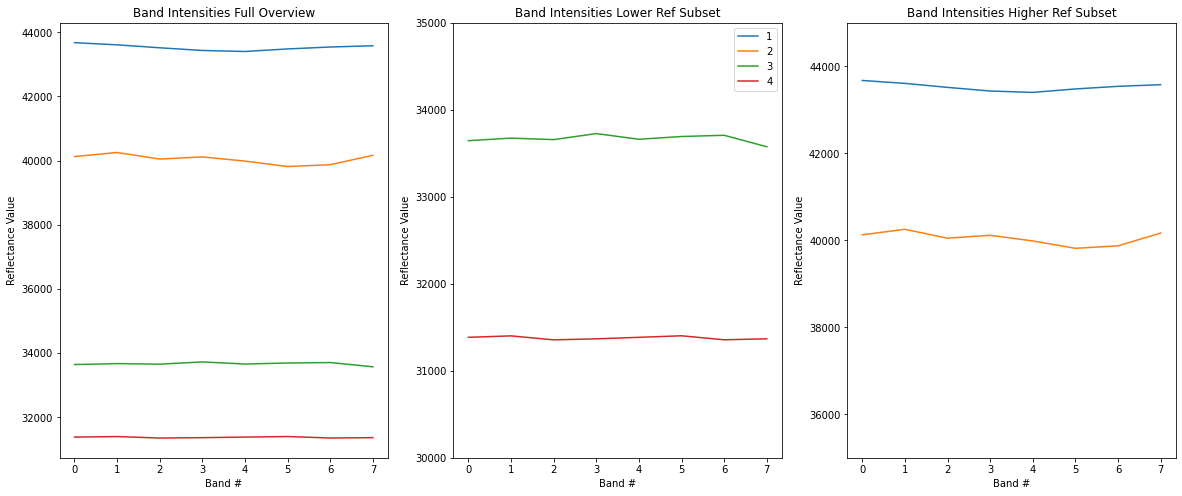

In [ ]:
ig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-8
band_count = np.arange(0,8)

classes = np.unique(Target)
for class_type in classes:
    band_intensity = np.mean(Input[Target==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
ax[1].set_ylim(30000,35000)
ax[2].set_ylim(35000,45000)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

In this step, we are going to creat our models:

1: KNN

2:  Logistic Regression 

3: SVM 

4: Rndom Forest 

In [15]:
#Split the train and test data
X_train, X_val, y_train, y_val = train_test_split( Input, Target, test_size=0.20, random_state=42)
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

In [16]:
Input.shape

(185491, 8)

#1: KNN

In [ ]:
#KNN 
k_range = range(24)
# used a repeated 1 fold cross validation on the training data set
Accu_result=[]

for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores_knn = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    #  append mean of scores for k neighbors to k_scores list
    Accu_result.append(scores_knn.mean())




print(Accu_result)
best_accu_knn=np.max(Accu_result[1:])
best_k=Accu_result[1:].index(best_accu_knn)
print(best_accu_knn)
print(best_k)


# test the trained model on the validation or test dataset
from sklearn import metrics
knn_test= neighbors.KNeighborsClassifier(n_neighbors=best_k, weights='distance')
fitted_knn=knn_test.fit(X_train,y_train)
y_pred_knn = fitted_knn.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred_knn))

[nan, 0.42755677197608327, 0.5256208184377548, 0.5153976640378517, 0.5531292930463525, 0.5363828465965969, 0.5443289982741988, 0.5762035401903158, 0.5774974201987223, 0.565145706322434, 0.5651793949578122, 0.5664193552576632, 0.5667697831840733, 0.5803277705412759, 0.5805770953244973, 0.5673965109606816, 0.5677267155337913, 0.5678278005125634, 0.5815879360300105, 0.5818911909663269, 0.5817564073617475, 0.5823426979680739, 0.5824168324018317, 0.5826392043694868]
0.5826392043694868
22
0.5906358661958543


In [ ]:
knn = neighbors.KNeighborsClassifier(n_neighbors=22, weights='distance')
fitted_knn=knn.fit(X_train,y_train)


#2: Random Forest

In [ ]:
#Random Forest
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 0, stop = 500, num =5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 15, num = 2)]
max_depth.append(None)
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



#  create the base model to tune using 10 fold cross validation
rf = RandomForestClassifier()

# search across 100 different combinations, and use all available cores
rf_tune = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42)



# Fit the random  model
rf_tune.fit(X_train, y_train)

RF_accuracy = evaluate(best_rf_estimator, X_val, y_val)


# test the trained model on the validation or test dataset rf
best_rf_params=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)




best_rf_params=rf_tune.best_params_
print(best_rf_params)
best_rf_estimator = rf_tune.best_estimator_
print(best_rf_estimator)  
 # model prediction
best_rf_params.fit(X_train, y_train)
y_pred_rf = best_rf_params.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred_rf))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=  36.7s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.7s remaining:    0.0s


[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=  36.9s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=  37.0s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=  36.9s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=  37.1s
[CV] n_estimators=125, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=125, min_samples_

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 33.4min finished


{'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 15, 'bootstrap': False}
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.604167228227176


In [ ]:
best_rf_params=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


best_rf_params.fit(X_train, y_train)
y_pred_rf = best_rf_params.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred_rf))


0.604167228227176


# 3: Support Vector Machine

In [ ]:
#SVM

from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#hyperparameterizing 

param_grid = {'C': [100,1000], 'gamma': [0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
svm_model = GridSearchCV(SVC(), param_grid, cv=5,refit=True,verbose=2)

# create models SVM
svm_model.fit(X_train,y_train)


# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")


# test the trained model on the validation or test dataset rf
final_svm_model=svm_model.best_estimator_
final_svm_model.fit(X_train,y_train)
Y_pred_svm = final_svm_model.predict(X_val)


accuracy_score(y_val, Y_pred_svm)
print("Training set score for SVM: %f" % final_svm_model.score(X_train,y_train))
print("Testing  set score for SVM: %f" % final_svm_model.score(X_val, y_val))
print(metrics.accuracy_score(y_val, Y_pred_svm))


Best score for training data: nan 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.1 



In [ ]:
svm_model.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# XGBoost model


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier



param_tuning = {'learning_rate': [0.01, 0.1], 'max_depth': [3,5,10],
        'min_child_weight': [1, 3, 5],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [10, 200, 500],
        'objective': ['multi:softprob']}

xgb_model = XGBClassifier()

gsearch = GridSearchCV(estimator = xgb_model,param_grid = param_tuning,cv = 5,n_jobs = -1,verbose = 1)

gsearch.fit(X_train,y_train, early_stopping_rounds=5, eval_set=[(X_val, y_val)], verbose=False)

gpredict=gsearch.best_estimator_
 print(gpredict)


 
gpredict=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

gpredict=gsearch.best_estimator_
 print(gpredict)

gpredict.fit(X_train,y_train)
y_pred_xgb = gpredict.predict(X_val)
accuracy_score(y_val,y_pred_xgb)


0.6059732068249818

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score

gpredict=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

gpredict.fit(X_train,y_train)
y_pred_xgb = gpredict.predict(X_val)



accuracy_score(y_val,y_pred_xgb)

0.6083452384161299

#Convolutional Neural network

In [ ]:
# Building the Training Data 

Input_cc = np.array([], dtype=np.int64).reshape(0,8) 
Target_cc = np.array([], dtype=np.string_) 

# extract the raster values within the polygon (in the train shapefile)
with rasterio.open(All_features) as src:
    band_count = src.count
    for index, geom in enumerate(value_geom):
        train_feature = [mapping(geom)]
        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, train_feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        Target = np.append(Target,[train2010["Class"][index]] * out_image_reshaped.shape[0]) 
   # stack the pixels onto the pixel array
        Input = np.vstack((Input,out_image_reshaped)) 


In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import math
import matplotlib.pyplot as plt

# parameters for this script
batch_size = 32
num_classes = 3
epochs = 20
data_augmentation = True


# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_val, num_classes)

# Define a convolutional neural network
model =Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Compile the model before using it
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

# normalize the data
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255



# create a callback that will save the best model while training
save_best_model = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        shuffle=True,
                        callbacks=[save_best_model])

# train with data augmentation
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[save_best_model])
    
# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Evaluate the best model saved (i.e., model with best validation accuracy) on the test set
saved_model = load_model('best_model.h5')
scores = saved_model.evaluate(X_val, y_val, verbose=1)
print('Test accuracy:', scores[1])

ValueError: ignored

In [ ]:
with rasterio.open(All_features) as src:
   img = src.read()[:, 2000:3200, 3000:4200]
    #img = src.read()

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(8, 1200, 1200)
(1200, 1200, 8)


In [ ]:
class_prediction_knn = fitted_knn.predict(reshaped_img.reshape(-1, 8))
class_prediction_rf = best_rf_params.predict(reshaped_img.reshape(-1, 8))
class_prediction_gb = gpredict.predict(reshaped_img.reshape(-1, 8))

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction_knn = class_prediction_knn.reshape(reshaped_img[:, :, 0].shape)
class_prediction_rf = class_prediction_rf.reshape(reshaped_img[:, :, 0].shape)
class_prediction_gb = class_prediction_gb.reshape(reshaped_img[:, :, 0].shape)


In [ ]:
def str_class_to_int(class_array):
    class_array[class_array == 'Fen'] = 1
    class_array[class_array == 'Bog'] = 2
    class_array[class_array == 'pp'] = 3
    class_array[class_array == 'Water'] = 4
    return(class_array.astype(int))
class_prediction_knn=str_class_to_int(class_prediction_knn)
class_prediction_rf=str_class_to_int(class_prediction_rf)
class_prediction_gb=str_class_to_int(class_prediction_gb)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [ ]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else (255, 255, 255, 0) for key in range(0, 5)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', 5)

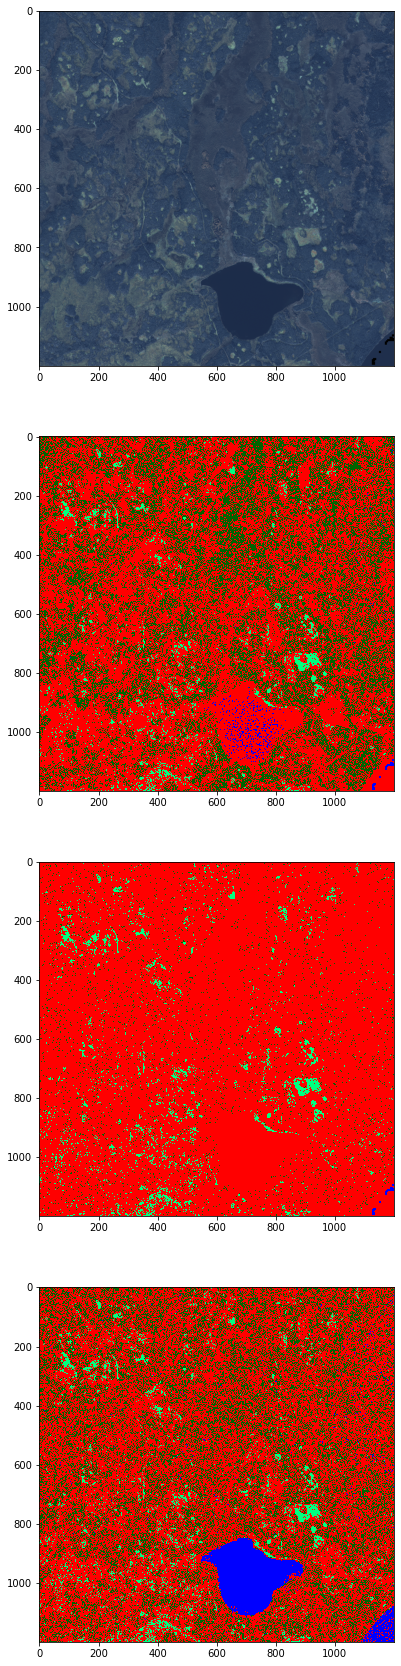

In [ ]:
fig, axs = plt.subplots(4,1,figsize=(15,30))

img_stretched = color_stretch(reshaped_img, [4, 3, 2])
axs[0].imshow(img_stretched)
cmap =  plt.matplotlib.colors.ListedColormap(["red", "springgreen", "darkgreen","blue"])

axs[1].imshow(class_prediction_rf, cmap=cmap, interpolation='none')
axs[2].imshow(class_prediction_knn, cmap=cmap, interpolation='none')
axs[3].imshow(class_prediction_gb, cmap=cmap, interpolation='none')



fig.show()

In [ ]:
qqq=pd.DataFrame(out_image.reshape([8,-1]).T)